In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/notebook
/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds


In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
#     "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
    "RU000A0JV4N8",
#     "RU000A0D0G29",
#     "RU000A0JPLH5",
#    "RU000A0JQ8V9",
#     "RU000A0JQAL8",
#     "RU000A0JQAM6",
    "RU000A0JQRD9",
    "RU000A0JWUB5",
#     "RU000A0JWUX9",
    "RU000A0JWV89",
#     "RU000A0JWVL2",
#     "RU000A0JWVT5",
#     "RU000A0JWWM8",
#     "RU000A0JWX04",
#     "RU000A0JWYJ0",
#     "RU000A0JWYQ5",
#     "RU000A0JWZY6",

#     "RU000A101MG4"
)

In [5]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        self._price = df_price.sort_index(level="date")

        self._dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        self._dur["date"] = self._dur["date"].dt.date
        self._dur = self._dur.set_index(["date", "isin"]).sort_index(level="date")

        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date
        self._rating["isin"] = self._rating["isincode"]

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")

    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]

bond_data = BondDataProvider()

In [6]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [7]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [8]:
bond_data.price.loc[(slice(None), slice(None)),].index.get_level_values('isin')
rating_reduced = bond_data.rating[
    bond_data.rating["isin"].isin(port.bond_universe)
    & (bond_data.rating.update_date < pd.Timestamp('2023-12-01'))
].sort_values("update_date")

rating_reduced.groupby("isin").num_rating.last()

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


isin
RU000A0JQRD9    100.0
RU000A0JUMH3     95.0
RU000A0JW0S4     90.0
Name: num_rating, dtype: float64

## Random Weights Strategy

In [9]:
%%time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    #price_today=price_today.reset_index(level='isin', col_level=0, col_fill='date')
    #print(bond_data.price.loc[bond_data.price.index.get_level_values('date')<=price_today])
    #price_today.loc[(slice(None),port.bond_universe),].isin
    print(price_today)
    new_weights = a / a.sum(axis=0, keepdims=1)
    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights)
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)
    

2023-08-01
date        isin        
2023-08-01  RU000A0GN9A7    0.75947
            RU000A0JWDN6    0.79060
            RU000A0JV4Q1    1.05295
            RU000A0JW0S4    0.91490
            RU000A0JUMH3    0.98300
            RU000A0JV4N8    1.04519
            RU000A0JQRD9    0.98400
            RU000A0JWUB5    0.79010
            RU000A0JWV89    0.90000
Name: mid, dtype: float64
wealth = 1.0
[0.05069621 0.1658406  0.18062708 0.08755787 0.17633815 0.14526447
 0.03936173 0.05109991 0.10321396]
[0.05069621 0.1658406  0.18062708 0.08755787 0.17633815 0.14526447
 0.03936173 0.05109991 0.10321396]
2023-08-02
date        isin        
2023-08-02  RU000A0GN9A7    0.75823
            RU000A0JWDN6    0.79060
            RU000A0JV4Q1    1.05108
            RU000A0JW0S4    0.91500
            RU000A0JUMH3    0.98290
            RU000A0JV4N8    1.04300
            RU000A0JQRD9    0.98350
            RU000A0JWUB5    0.79010
            RU000A0JWV89    0.90860
Name: mid, dtype: float64
wealth = 1.

date        isin        
2023-08-21  RU000A0GN9A7    0.75242
            RU000A0JWDN6    0.77370
            RU000A0JV4Q1    1.04384
            RU000A0JW0S4    0.89000
            RU000A0JUMH3    0.97950
            RU000A0JV4N8    1.04349
            RU000A0JQRD9    0.97290
            RU000A0JWUB5    0.84010
            RU000A0JWV89    0.92350
Name: mid, dtype: float64
wealth = 1.020776929380195
[0.10487584 0.11180236 0.05237482 0.08506717 0.16696001 0.14064416
 0.16478663 0.02998911 0.14349989]
[-0.10878744 -0.04442338  0.02746088 -0.12690671  0.03664432  0.08946856
  0.10237144 -0.08099097  0.1051633 ]
2023-08-22
date        isin        
2023-08-22  RU000A0GN9A7    0.75200
            RU000A0JWDN6    0.77830
            RU000A0JV4Q1    1.04252
            RU000A0JW0S4    0.88570
            RU000A0JUMH3    0.97540
            RU000A0JV4N8    1.04010
            RU000A0JQRD9    0.97280
            RU000A0JWUB5    0.84010
            RU000A0JWV89    0.89970
Name: mid, dtype: float64

2023-09-15
2023-09-16
2023-09-17
2023-09-18
date        isin        
2023-09-18  RU000A0GN9A7    0.72859
            RU000A0JWDN6    0.74990
            RU000A0JV4Q1    1.03924
            RU000A0JW0S4    0.87830
            RU000A0JUMH3    0.96690
            RU000A0JV4N8    1.03161
            RU000A0JQRD9    0.95410
            RU000A0JWUB5    0.84010
            RU000A0JWV89    0.84880
Name: mid, dtype: float64
wealth = 1.001190273570319
[0.20675171 0.08212229 0.17770716 0.11708127 0.19579276 0.1679195
 0.00771817 0.01877526 0.02613189]
[ 0.12686325 -0.10086997  0.14947659 -0.0499189   0.00737533  0.03868561
 -0.02242153  0.00515215 -0.15434252]
2023-09-19
date        isin        
2023-09-19  RU000A0GN9A7    0.72406
            RU000A0JWDN6    0.74170
            RU000A0JV4Q1    1.03866
            RU000A0JW0S4    0.86600
            RU000A0JUMH3    0.96840
            RU000A0JV4N8    1.03252
            RU000A0JQRD9    0.95410
            RU000A0JWUB5    0.84010
            RU000A

### Random Weights Strategy Results

In [10]:
wealth

0.9962951668996737

In [11]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [12]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

,dur_mod,yield,sharpe,sharpe_squared,weight
isin,,,,,
RU000A0JUMH3,0.588109,0.115846,0.196981,0.038802,0.650446
RU000A0JQRD9,1.132534,0.117461,0.103715,0.010757,0.180320
RU000A0JW0S4,1.855754,0.127511,0.068711,0.004721,0.079144
RU000A0JWDN6,2.274082,0.118546,0.052129,0.002717,0.045554
RU000A0JWV89,2.593502,0.095057,0.036652,0.001343,0.022519
RU000A0JWUB5,2.772511,0.070683,0.025494,0.000650,0.010895
RU000A0GN9A7,6.657464,0.115169,0.017299,0.000299,0.005017
RU000A0JV4N8,5.636553,0.081891,0.014529,0.000211,0.003538
RU000A0JV4Q1,6.702876,0.082937,0.012373,0.000153,0.002566


In [13]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JQRD9  1.132534  0.117461  0.103715
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0JWV89  2.593502  0.095057  0.036652
           RU000A0JWUB5  2.772511  0.070683  0.025494
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [14]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [15]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [16]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = 0.0
2023-08-02
wealth = 1.0000344573973512
cash = 0.0
2023-08-03
wealth = 0.9986303937923651
cash = 0.0
2023-08-04
wealth = 0.9990225074061394
cash = -1.1102230246251565e-16
2023-08-05
2023-08-06
2023-08-07
wealth = 0.997690427075624
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9966846413990299
cash = -1.1102230246251565e-16
2023-08-09
wealth = 0.9974253241987139
cash = -3.3306690738754696e-16
2023-08-10
2023-08-11
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9965810792064576
cash = 0.0
2023-08-15
wealth = 0.9878933987644237
cash = 1.1102230246251565e-16
2023-08-16
wealth = 0.9945862535275313
cash = 0.0
2023-08-17
wealth = 0.9906304128432077
cash = 1.1102230246251565e-16
2023-08-18
wealth = 0.9937604779554495
cash = 2.220446049250313e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9973086791349274
cash = -2.220446049250313e-16
2023-08-22
wealth = 0.994075223725385
cash = -1.1102230246251565e-16
2023-08-23
wealth = 0.9938929131632144
cash = 1.1102230

### Sharpe Ratio Strategy Results

In [17]:
wealth

0.9830220431908732

## Quadratic optimization

In [18]:
# create portfolio for a quadratic optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [19]:
%%time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-07-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]

    if price_today.empty:
        continue
        
    if len(price_today) < len(port.bond_universe):
        continue

    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    if len(today_bond_data) < len(port.bond_universe):
        continue
    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    
    today_info["num_rating"] = today_info["num_rating"].fillna(0)

    #
    # make predictions
    #
    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-07-01
2023-07-02
2023-07-03
wealth = 1.0
cash = -8.784084570834239e-13
2023-07-04
2023-07-05
2023-07-06
wealth = 1.0022346890347031
cash = -6.562750343164225e-11
2023-07-07
wealth = 1.0027426023383745
cash = -1.0134115768778429e-12
2023-07-08
2023-07-09
2023-07-10
wealth = 1.0026409970488432
cash = -5.715428130770306e-13
2023-07-11
wealth = 1.001421610004696
cash = -1.396660564978447e-12
2023-07-12
wealth = 1.0026424836529686
cash = -7.460698725481052e-13
2023-07-13
wealth = 1.0015247105385272
cash = -2.0750068330244176e-12
2023-07-14
wealth = 1.0003548238781705
cash = -1.6515677714323829e-12
2023-07-15
2023-07-16
2023-07-17
wealth = 0.9997437335764607
cash = -2.1378454562182014e-12
2023-07-18
wealth = 1.001272393719544
cash = -7.685185821060259e-12
2023-07-19
2023-07-20
wealth = 1.0022899469652535
cash = -2.9547475577373916e-12
2023-07-21
wealth = 1.0006148486280788
cash = -1.965094753586527e-13
2023-07-22
2023-07-23
2023-07-24
wealth = 1.000056413146855
cash = -1.920685832601521

In [20]:
wealth

0.9766973261343168

# Linear programming

In [21]:
from models.linear_programming import linear_minimize

In [22]:
# create portfolio for a linear programming optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [28]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-03-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue
        
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    print(1,price_today)
    print(len(price_today.index))
    print(len(port.bond_universe))
    #price_today=price_today.reset_index()
    print(2,price_today)
    if price_today is None or price_today.empty:
        continue    
    
    if len(price_today) <8:
        print("We have this conflict")
    if len(price_today) < len(port.bond_universe):
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    rating_reduced = today_info["num_rating"]

    new_weights=linear_minimize(today_info, weight_at_least=0.1)
    
    if new_weights is None:
        print("No answer for you")
        
    print(new_weights)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-03-01
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-01 RU000A0GN9A7  0.00154  0.77198  0.77044  0.00284  0.77198  0.77198
           RU000A0JQRD9  0.00190  0.99490  0.99300  0.00903  0.99360  0.99360
           RU000A0JUMH3  0.00010  0.97930  0.97940  0.01804  0.97930  0.97930
           RU000A0JV4N8  0.00152  1.05252  1.05100  0.02983  1.05219  1.05219
           RU000A0JV4Q1  0.00110  1.05759  1.05649  0.01854  1.05608  1.05608
           RU000A0JW0S4  0.00000  0.87980  0.87980  0.01082  0.87710  0.87710
           RU000A0JWDN6  0.00940  0.76890  0.75950  0.00004  0.76890  0.76890
           RU000A0JWV89  0.02620  0.94900  0.92280  0.01266  0.94900  0.94900
8
9
2                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-01 RU000A0GN9A7  0.00154  0.77198  0.

1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-17 RU000A0GN9A7  0.00096  0.77349  0.77253  0.00624  0.77263  0.77263
           RU000A0JQRD9  0.00140  0.99180  0.99040  0.01290  0.99160  0.99160
           RU000A0JUMH3  0.00050  0.97650  0.97600  0.02132  0.97650  0.97650
           RU000A0JV4N8  0.00118  1.05199  1.05081  0.03489  1.05081  1.05081
           RU000A0JV4Q1  0.00119  1.05518  1.05399  0.02324  1.05518  1.05518
           RU000A0JW0S4  0.00400  0.88800  0.88400  0.01329  0.88790  0.88790
           RU000A0JWDN6  0.00740  0.75320  0.74580  0.00004  0.74510  0.74510
           RU000A0JWV89  0.02800  0.92000  0.89200  0.01414  0.91990  0.91990
8
9
2                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-17 RU000A0GN9A7  0.00096  0.77349  0.77253  0.00

1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-28 RU000A0GN9A7  0.00039  0.77219  0.77180  0.00794  0.77244  0.77244
           RU000A0JQRD9  0.00010  0.98850  0.98840  0.01484  0.98840  0.98840
           RU000A0JUMH3  0.00090  0.97850  0.97760  0.02296  0.97760  0.97760
           RU000A0JV4N8  0.00146  1.06048  1.05902  0.03742  1.06047  1.06047
           RU000A0JV4Q1  0.00074  1.05778  1.05704  0.02559  1.05702  1.05702
           RU000A0JW0S4  0.00070  0.88540  0.88470  0.01452  0.88540  0.88540
           RU000A0JWDN6  0.00010  0.74020  0.74010  0.00005  0.74020  0.74020
           RU000A0JWV89  0.02700  0.92000  0.89300  0.01488  0.93500  0.93500
8
9
2                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-03-28 RU000A0GN9A7  0.00039  0.77219  0.77180  0.00

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9875191754492645
cash = -4.440892098500626e-16
2023-04-05
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-04-05 RU000A0GN9A7  0.00186  0.76799  0.76613  0.00945  0.76650  0.76650
           RU000A0JQRD9  0.00100  0.99000  0.98900  0.01656  0.99000  0.99000
           RU000A0JUMH3  0.00010  0.97840  0.97850  0.02441  0.97850  0.97850
           RU000A0JV4N8  0.00134  1.06138  1.06004  0.03967  1.06009  1.06009
           RU000A0JV4Q1  0.00143  1.05946  1.05803  0.02768  1.05854  1.05854
           RU000A0JW0S4  0.00100  0.88700  0.88600  0.01562  0.88700  0.88700
           RU000A0JWDN6  0.01400  0.74480  0.73080  0.00005  0.74080  0.74080
           RU000A0JWUB5  0.05990  0.84010  0.78020  0.00022  0.84010  0.84010
           RU000A0JWV89  0.01920  0.89000  0.87080  0.00058  0.89170  0.89170
9
9
2                           s

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9814087971735864
cash = -1.1102230246251565e-16
2023-04-14
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-04-14 RU000A0GN9A7  0.00047  0.76250  0.76203  0.01153  0.76203  0.76203
           RU000A0JQRD9  0.00050  0.98890  0.98840  0.01893  0.98890  0.98890
           RU000A0JUMH3  0.00100  0.98100  0.98000  0.02642  0.98100  0.98100
           RU000A0JV4N8  0.00148  1.06150  1.06002  0.04277  1.06012  1.06012
           RU000A0JV4Q1  0.00083  1.05933  1.05850  0.03055  1.05933  1.05933
           RU000A0JW0S4  0.00150  0.89000  0.88850  0.01712  0.89000  0.89000
           RU000A0JWDN6  0.00190  0.75440  0.75250  0.00000  0.75400  0.75400
           RU000A0JWUB5  0.20000      NaN      NaN  0.00052  0.84010  0.84010
           RU000A0JWV89  0.00720  0.83790  0.83070  0.00148  0.83790  0.83790
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9805913720923327
cash = -3.3306690738754696e-16
2023-04-21
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-04-21 RU000A0GN9A7  0.00086  0.76249  0.76163  0.01286  0.76163  0.76163
           RU000A0JQRD9  0.00010  0.99000  0.98990  0.02043  0.99000  0.99000
           RU000A0JUMH3  0.00220  0.98050  0.97830  0.02769  0.98050  0.98050
           RU000A0JV4N8  0.00039  1.06090  1.06051  0.04474  1.06090  1.06090
           RU000A0JV4Q1  0.00096  1.05883  1.05787  0.03238  1.05787  1.05787
           RU000A0JW0S4  0.00180  0.90190  0.90010  0.01808  0.90940  0.90940
           RU000A0JWDN6  0.00110  0.75500  0.75390  0.00000  0.75500  0.75500
           RU000A0JWUB5  0.05980  0.84010  0.78030  0.00071  0.84010  0.84010
           RU000A0JWV89  0.00840  0.82990  0.82150  0.00205  0.82990  0.82990
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9814301415044406
cash = 0.0
2023-04-28
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-04-28 RU000A0GN9A7  0.00013  0.76280  0.76267  0.01437  0.76280  0.76280
           RU000A0JQRD9  0.00140  0.98980  0.98840  0.02215  0.98840  0.98840
           RU000A0JUMH3  0.00170  0.98020  0.97850  0.02915  0.98020  0.98020
           RU000A0JV4N8  0.00136  1.05737  1.05601  0.04699  1.05734  1.05734
           RU000A0JV4Q1  0.00099  1.05803  1.05704  0.03447  1.05769  1.05769
           RU000A0JW0S4  0.01370  0.90390  0.89020  0.01918  0.89580  0.89580
           RU000A0JWDN6  0.00660  0.75280  0.74620  0.00001  0.75280  0.75280
           RU000A0JWUB5  0.05990  0.84010  0.78020  0.00093  0.84010  0.84010
           RU000A0JWV89  0.00470  0.82000  0.81530  0.00271  0.82000  0.82000
9
9
2                           spread      ask     

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9797806833234022
cash = -2.220446049250313e-16
2023-05-06
2023-05-07
2023-05-08
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-05-08 RU000A0GN9A7  0.00120  0.76349  0.76229  0.01588  0.76350  0.76350
           RU000A0JQRD9  0.00190  0.99230  0.99040  0.02387  0.99200  0.99200
           RU000A0JUMH3  0.00440  0.98750  0.98310  0.03061  0.98350  0.98350
           RU000A0JV4N8  0.00122  1.05916  1.05794  0.04924  1.05795  1.05795
           RU000A0JV4Q1  0.00068  1.05848  1.05780  0.03655  1.05891  1.05891
           RU000A0JW0S4  0.01150  0.90210  0.89060  0.02027  0.90030  0.90030
           RU000A0JWDN6  0.00430  0.75490  0.75060  0.00001  0.75430  0.75430
           RU000A0JWUB5  0.05990  0.84010  0.78020  0.00115  0.84010  0.84010
           RU000A0JWV89  0.03110  0.84650  0.81540  0.00337  0.84650  0.84650
9
9
2      

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9811680411184643
cash = -1.1102230246251565e-16
2023-05-16
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-05-16 RU000A0GN9A7  0.00088  0.76499  0.76411  0.01721  0.76499  0.76499
           RU000A0JQRD9  0.00160  0.98980  0.98820  0.02538  0.98950  0.98950
           RU000A0JUMH3  0.00190  0.98510  0.98320  0.03188  0.98520  0.98520
           RU000A0JV4N8  0.00137  1.05447  1.05310  0.00000  1.05319  1.05319
           RU000A0JV4Q1  0.00129  1.05830  1.05701  0.03838  1.05830  1.05830
           RU000A0JW0S4  0.00730  0.90200  0.89470  0.02123  0.90200  0.90200
           RU000A0JWDN6  0.00390  0.75650  0.75260  0.00001  0.75650  0.75650
           RU000A0JWUB5  0.05090  0.87010  0.81920  0.00134  0.84010  0.84010
           RU000A0JWV89  0.00610  0.82520  0.81910  0.00395  0.82520  0.82520
9
9
2                           

[0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.1]
wealth = 0.9836291982026852
cash = -3.3306690738754696e-16
2023-05-23
1                           spread      ask     bid       ai     last      mid
date       isin                                                             
2023-05-23 RU000A0GN9A7  0.00090  0.76430  0.7634  0.01853  0.76430  0.76430
           RU000A0JQRD9  0.00050  0.99000  0.9895  0.02688  0.99000  0.99000
           RU000A0JUMH3  0.00230  0.98490  0.9826  0.00018  0.98230  0.98230
           RU000A0JV4N8  0.00144  1.05444  1.0530  0.00167  1.05443  1.05443
           RU000A0JV4Q1  0.00100  1.06030  1.0593  0.04021  1.06021  1.06021
           RU000A0JW0S4  0.00400  0.88780  0.8838  0.02219  0.88790  0.88790
           RU000A0JWDN6  0.00020  0.75600  0.7558  0.00001  0.75590  0.75590
           RU000A0JWUB5  0.05990  0.87010  0.8102  0.00153  0.84010  0.84010
           RU000A0JWV89  0.01100  0.84650  0.8355  0.00452  0.84650  0.84650
9
9
2                           spread     

[0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.1]
wealth = 0.9824472861307619
cash = -2.220446049250313e-16
2023-05-30
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-05-30 RU000A0GN9A7  0.00064  0.76350  0.76286  0.01985  0.76350  0.76350
           RU000A0JQRD9  0.00130  0.99140  0.99010  0.02839  0.99140  0.99140
           RU000A0JUMH3  0.00170  0.98690  0.98520  0.00146  0.98690  0.98690
           RU000A0JV4N8  0.00082  1.05232  1.05150  0.00334  1.05150  1.05150
           RU000A0JV4Q1  0.00180  1.06188  1.06008  0.04204  1.06176  1.06176
           RU000A0JW0S4  0.00490  0.89990  0.89500  0.02315  0.89440  0.89440
           RU000A0JWDN6  0.00470  0.75990  0.75520  0.00001  0.75900  0.75900
           RU000A0JWUB5  0.05980  0.87000  0.81020  0.00173  0.84010  0.84010
           RU000A0JWV89  0.00300  0.83320  0.83020  0.00510  0.83000  0.83000
9
9
2                           s

[0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.1]
wealth = 0.9845923161539932
cash = -3.3306690738754696e-16
2023-06-06
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-06-06 RU000A0GN9A7  0.00079  0.76290  0.76211  0.02118  0.76290  0.76290
           RU000A0JQRD9  0.00080  0.98750  0.98670  0.02989  0.98750  0.98750
           RU000A0JUMH3  0.00020  0.98390  0.98370  0.00273  0.98390  0.98390
           RU000A0JV4N8  0.00153  1.05215  1.05062  0.00501  1.05211  1.05211
           RU000A0JV4Q1  0.00215  1.06311  1.06096  0.04386  1.06269  1.06269
           RU000A0JW0S4  0.00000  0.90100  0.90100  0.02411  0.90100  0.90100
           RU000A0JWDN6  0.00490  0.77990  0.77500  0.00002  0.78100  0.78100
           RU000A0JWUB5  0.02010  0.83040  0.81030  0.00192  0.84010  0.84010
           RU000A0JWV89  0.01820  0.85000  0.83180  0.00567  0.84990  0.84990
9
9
2                           

[0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.1]
wealth = 0.9906151462293512
cash = -1.1102230246251565e-16
2023-06-15
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-06-15 RU000A0GN9A7  0.00107  0.76258  0.76151  0.02288  0.76258  0.76258
           RU000A0JQRD9  0.00040  0.98850  0.98810  0.03183  0.98850  0.98850
           RU000A0JUMH3  0.00010  0.98490  0.98480  0.00437  0.98480  0.98480
           RU000A0JV4N8  0.00094  1.05194  1.05100  0.00716  1.05194  1.05194
           RU000A0JV4Q1  0.00048  1.06199  1.06151  0.04621  1.06212  1.06212
           RU000A0JW0S4  0.00200  0.91500  0.91300  0.00041  0.91500  0.91500
           RU000A0JWDN6  0.02030  0.79850  0.77820  0.00002  0.79860  0.79860
           RU000A0JWUB5  0.06990  0.88010  0.81020  0.00216  0.84010  0.84010
           RU000A0JWV89  0.09990  0.94930  0.84940  0.00641  0.94940  0.94940
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9992890370596286
cash = -1.1102230246251565e-16
2023-06-22
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-06-22 RU000A0GN9A7  0.00151  0.76280  0.76129  0.02420  0.76280  0.76280
           RU000A0JQRD9  0.00010  0.98670  0.98660  0.03334  0.98660  0.98660
           RU000A0JUMH3  0.00090  0.98300  0.98210  0.00565  0.98300  0.98300
           RU000A0JV4N8  0.00135  1.05154  1.05019  0.00883  1.05158  1.05158
           RU000A0JV4Q1  0.00080  1.06180  1.06100  0.00048  1.06182  1.06182
           RU000A0JW0S4  0.00510  0.91640  0.91130  0.00137  0.91610  0.91610
           RU000A0JWDN6  0.00350  0.79260  0.78910  0.00002  0.78830  0.78830
           RU000A0JWV89  0.07280  0.92900  0.85620  0.00699  0.92990  0.92990
8
9
2                           spread      ask      bid       ai     last      mid
date       isin           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0003698707021216
cash = -2.220446049250313e-16
2023-07-04
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-07-04 RU000A0GN9A7  0.00009  0.75960  0.75951  0.02647  0.75951  0.75951
           RU000A0JQRD9  0.00000  0.98350  0.98350  0.03592  0.98350  0.98350
           RU000A0JUMH3  0.00230  0.98500  0.98270  0.00783  0.98260  0.98260
           RU000A0JV4N8  0.00194  1.04696  1.04502  0.01169  1.04944  1.04944
           RU000A0JV4Q1  0.00027  1.06147  1.06120  0.00338  1.06197  1.06197
           RU000A0JW0S4  0.00870  0.91990  0.91120  0.00301  0.92960  0.92960
           RU000A0JWDN6  0.00710  0.79510  0.78800  0.00002  0.79460  0.79460
           RU000A0JWV89  0.06730  0.92550  0.85820  0.00797  0.92970  0.92970
8
9
2                           spread      ask      bid       ai     last      mid
date       isin            

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.997021109278826
cash = -2.220446049250313e-16
2023-07-11
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-07-11 RU000A0GN9A7  0.00082  0.75751  0.75669  0.02779  0.75751  0.75751
           RU000A0JQRD9  0.00070  0.98750  0.98680  0.00000  0.98750  0.98750
           RU000A0JUMH3  0.00020  0.98430  0.98410  0.00911  0.98430  0.98430
           RU000A0JV4N8  0.00146  1.04848  1.04702  0.01336  1.04701  1.04701
           RU000A0JV4Q1  0.00120  1.05948  1.05828  0.00507  1.05948  1.05948
           RU000A0JW0S4  0.00490  0.90890  0.90400  0.00397  0.90910  0.90910
           RU000A0JWDN6  0.01360  0.81000  0.79640  0.00003  0.80380  0.80380
           RU000A0JWUB5  0.20000      NaN  0.79010  0.00288  0.84010  0.84010
           RU000A0JWV89  0.05960  0.92080  0.86120  0.00855  0.90890  0.90890
9
9
2                           sp

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9910544499792929
cash = -1.1102230246251565e-16
2023-07-18
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-07-18 RU000A0GN9A7  0.00050  0.75750  0.75700  0.02912  0.75700  0.75700
           RU000A0JQRD9  0.20000      NaN      NaN  0.00000  0.98750  0.98750
           RU000A0JUMH3  0.00160  0.98400  0.98240  0.01038  0.98400  0.98400
           RU000A0JV4N8  0.00138  1.04839  1.04701  0.01503  1.04839  1.04839
           RU000A0JV4Q1  0.00071  1.05697  1.05626  0.00677  1.05697  1.05697
           RU000A0JW0S4  0.00450  0.91460  0.91010  0.00493  0.91000  0.91000
           RU000A0JWDN6  0.00320  0.79590  0.79270  0.00003  0.79590  0.79590
           RU000A0JWUB5  0.04980  0.84010  0.79030  0.00307  0.79010  0.79010
           RU000A0JWV89  0.03060  0.91990  0.88930  0.00912  0.92000  0.92000
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9904054351878042
cash = -3.3306690738754696e-16
2023-07-25
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-07-25 RU000A0GN9A7  0.00147  0.75798  0.75651  0.03044  0.75651  0.75651
           RU000A0JQRD9  0.00080  0.98430  0.98350  0.00129  0.98430  0.98430
           RU000A0JUMH3  0.00170  0.98480  0.98310  0.01166  0.98460  0.98460
           RU000A0JV4N8  0.00128  1.04630  1.04502  0.01670  1.04636  1.04636
           RU000A0JV4Q1  0.00194  1.05747  1.05553  0.00846  1.05747  1.05747
           RU000A0JW0S4  0.00460  0.91380  0.90920  0.00589  0.90920  0.90920
           RU000A0JWDN6  0.01060  0.79720  0.78660  0.00003  0.79600  0.79600
           RU000A0JWUB5  0.00420  0.79560  0.79140  0.00326  0.79010  0.79010
           RU000A0JWV89  0.00020  0.87860  0.87840  0.00970  0.87860  0.87860
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9858358442131561
cash = -3.3306690738754696e-16
2023-08-01
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-08-01 RU000A0GN9A7  0.00146  0.75948  0.75802  0.03176  0.75947  0.75947
           RU000A0JQRD9  0.00090  0.98400  0.98310  0.00280  0.98400  0.98400
           RU000A0JUMH3  0.00090  0.98300  0.98210  0.01294  0.98300  0.98300
           RU000A0JV4N8  0.00001  1.04520  1.04519  0.01837  1.04519  1.04519
           RU000A0JV4Q1  0.00010  1.05295  1.05285  0.01015  1.05295  1.05295
           RU000A0JW0S4  0.01280  0.91490  0.90210  0.00685  0.91490  0.91490
           RU000A0JWDN6  0.00050  0.79060  0.79010  0.00003  0.79060  0.79060
           RU000A0JWUB5  0.07130  0.86140  0.79010  0.00345  0.79010  0.79010
           RU000A0JWV89  0.06120  0.91940  0.85820  0.01027  0.90000  0.90000
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9879635581404345
cash = -1.1102230246251565e-16
2023-08-08
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-08-08 RU000A0GN9A7  0.00171  0.75979  0.75808  0.03309  0.75809  0.75809
           RU000A0JQRD9  0.00080  0.98430  0.98350  0.00430  0.98430  0.98430
           RU000A0JUMH3  0.00310  0.98280  0.97970  0.01421  0.98300  0.98300
           RU000A0JV4N8  0.00254  1.04549  1.04295  0.02004  1.04300  1.04300
           RU000A0JV4Q1  0.00105  1.05349  1.05244  0.01184  1.05243  1.05243
           RU000A0JW0S4  0.00620  0.88980  0.88360  0.00781  0.88980  0.88980
           RU000A0JWDN6  0.00260  0.79660  0.79400  0.00003  0.79400  0.79400
           RU000A0JWUB5  0.05000  0.84010  0.79010  0.00364  0.79010  0.79010
           RU000A0JWV89  0.01470  0.86740  0.85270  0.01085  0.85210  0.85210
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9819348516203027
cash = -3.3306690738754696e-16
2023-08-15
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-08-15 RU000A0GN9A7  0.00050  0.75240  0.75190  0.00000  0.75190  0.75190
           RU000A0JQRD9  0.00010  0.97600  0.97590  0.00581  0.97600  0.97600
           RU000A0JUMH3  0.00000  0.96930  0.96930  0.01549  0.96930  0.96930
           RU000A0JV4N8  0.00124  1.03676  1.03552  0.02172  1.03676  1.03676
           RU000A0JV4Q1  0.00102  1.04448  1.04346  0.01353  1.04448  1.04448
           RU000A0JW0S4  0.01210  0.89120  0.87910  0.00877  0.89110  0.89110
           RU000A0JWDN6  0.01940  0.78490  0.76550  0.00003  0.78490  0.78490
           RU000A0JWUB5  0.05000  0.84010  0.79010  0.00384  0.79010  0.79010
           RU000A0JWV89  0.02030  0.89030  0.87000  0.01142  0.85020  0.85020
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9915177753323495
cash = 1.1102230246251565e-16
2023-08-22
1                           spread     ask      bid       ai     last      mid
date       isin                                                             
2023-08-22 RU000A0GN9A7  0.00077  0.7520  0.75123  0.00132  0.75200  0.75200
           RU000A0JQRD9  0.00000  0.9728  0.97280  0.00731  0.97280  0.97280
           RU000A0JUMH3  0.00000  0.9754  0.97540  0.01676  0.97540  0.97540
           RU000A0JV4N8  0.00040  1.0405  1.04010  0.02339  1.04010  1.04010
           RU000A0JV4Q1  0.00149  1.0440  1.04251  0.01522  1.04252  1.04252
           RU000A0JW0S4  0.00000  0.8857  0.88570  0.00973  0.88570  0.88570
           RU000A0JWDN6  0.01540  0.7782  0.76280  0.00004  0.77830  0.77830
           RU000A0JWUB5  0.05000     NaN  0.79010  0.00403  0.84010  0.84010
           RU000A0JWV89  0.03150  0.8998  0.86830  0.01200  0.89970  0.89970
9
9
2                           spread     a

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9866042684051887
cash = -3.3306690738754696e-16
2023-08-29
1                           spread      ask     bid       ai     last      mid
date       isin                                                             
2023-08-29 RU000A0GN9A7  0.00099  0.74999  0.7490  0.00265  0.74999  0.74999
           RU000A0JQRD9  0.00220  0.97030  0.9681  0.00882  0.96790  0.96790
           RU000A0JUMH3  0.00000  0.97300  0.9730  0.01804  0.97300  0.97300
           RU000A0JV4N8  0.00178  1.03828  1.0365  0.02506  1.03860  1.03860
           RU000A0JV4Q1  0.00165  1.04465  1.0430  0.01692  1.04300  1.04300
           RU000A0JW0S4  0.00390  0.89890  0.8950  0.01068  0.89890  0.89890
           RU000A0JWDN6  0.01840  0.77900  0.7606  0.00004  0.77970  0.77970
           RU000A0JWUB5  0.02990  0.82000  0.7901  0.00422  0.84010  0.84010
           RU000A0JWV89  0.02900  0.88620  0.8572  0.01258  0.86830  0.86830
9
9
2                           spread     

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9795207260151053
cash = 0.0
2023-09-05
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-09-05 RU000A0GN9A7  0.00292  0.74076  0.73784  0.00397  0.74079  0.74079
           RU000A0JQRD9  0.00110  0.96320  0.96210  0.01032  0.96320  0.96320
           RU000A0JUMH3  0.00460  0.98030  0.97570  0.01931  0.97800  0.97800
           RU000A0JV4N8  0.00189  1.03690  1.03501  0.02673  1.03502  1.03502
           RU000A0JV4Q1  0.00078  1.04464  1.04386  0.01861  1.04386  1.04386
           RU000A0JW0S4  0.00280  0.87730  0.87450  0.01164  0.87400  0.87400
           RU000A0JWDN6  0.01470  0.77510  0.76040  0.00004  0.77640  0.77640
           RU000A0JWUB5  0.20000      NaN  0.79010  0.00441  0.84010  0.84010
           RU000A0JWV89  0.03190  0.88200  0.85010  0.01315  0.88840  0.88840
9
9
2                           spread      ask     

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9755922069021231
cash = -1.1102230246251565e-16
2023-09-13
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-09-13 RU000A0GN9A7  0.00169  0.73000  0.72831  0.00548  0.73000  0.73000
           RU000A0JQRD9  0.00000  0.95430  0.95430  0.01204  0.95430  0.95430
           RU000A0JUMH3  0.00210  0.96970  0.96760  0.02077  0.96970  0.96970
           RU000A0JV4N8  0.00042  1.03400  1.03358  0.02864  1.03358  1.03358
           RU000A0JV4Q1  0.00040  1.04339  1.04299  0.02054  1.04339  1.04339
           RU000A0JW0S4  0.00560  0.84780  0.84220  0.01274  0.84800  0.84800
           RU000A0JWDN6  0.03460  0.76590  0.73130  0.00004  0.76750  0.76750
           RU000A0JWUB5  0.20000      NaN  0.79010  0.00463  0.84010  0.84010
           RU000A0JWV89  0.02400  0.83900  0.81500  0.01381  0.82000  0.82000
9
9
2                           

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9672863184853857
cash = 0.0
2023-09-20
1                           spread      ask      bid       ai     last      mid
date       isin                                                              
2023-09-20 RU000A0GN9A7  0.00148  0.72419  0.72271  0.00681  0.72419  0.72419
           RU000A0JQRD9  0.00120  0.95410  0.95290  0.01355  0.95300  0.95300
           RU000A0JUMH3  0.00250  0.96990  0.96740  0.02205  0.97000  0.97000
           RU000A0JV4N8  0.00172  1.03248  1.03076  0.03031  1.03248  1.03248
           RU000A0JV4Q1  0.00073  1.03780  1.03707  0.02223  1.03780  1.03780
           RU000A0JW0S4  0.00440  0.85990  0.85550  0.01370  0.85990  0.85990
           RU000A0JWDN6  0.00540  0.75460  0.74920  0.00004  0.75460  0.75460
           RU000A0JWUB5  0.20000      NaN  0.79010  0.00482  0.84010  0.84010
           RU000A0JWV89  0.01710  0.83710  0.82000  0.01438  0.82090  0.82090
9
9
2                           spread      ask     

In [24]:
wealth

0.9766973261343168

In [25]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [26]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

TypeError: no numeric data to plot

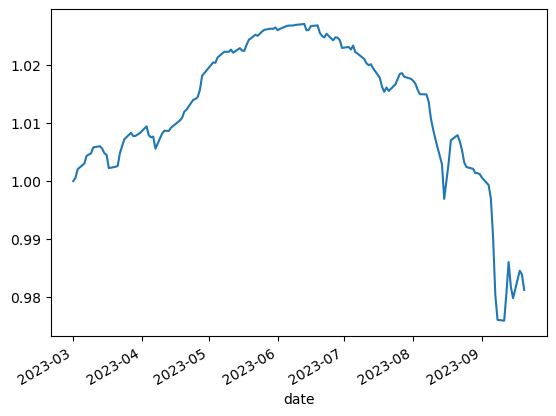

In [27]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")

plt.legend()
plt.ylabel("PNL");

### mean and median return

In [ ]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

## Sharpe Ratio

In [ ]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [ ]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

### Information Ratio

In [ ]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [ ]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

## Returns

In [ ]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

In [ ]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [ ]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [ ]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

## Value at Risk

In [ ]:
alpha = 0.05
returns_benchmark.quantile(alpha)

## Skewness of Returns

In [ ]:
alpha = 0.05
returns_benchmark.skew()